In [1]:
import sys
sys.path.append("../") 

import torch
from torchvision.transforms import transforms
import numpy as np
from math import log

import matplotlib.pyplot as plt
from torchsummary import summary

from models.decoder import *
from models.cirtorch_network import init_network, extract_vectors
from models.cirtorch_utils.genericdataset import ImagesFromList

from common.scheduler import LearningRateScheduler

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
batch_size = 10
resolution = 128
overfit = 10

In [4]:
cir = init_network({'architecture' : 'resnet34'}).to(device)
#dec = DecoderV1(input_size=512, out_res = resolution, start_channels=32, resolution_expansion_factor=6)
dec = DecoderV2(input_size=512, out_res = resolution, start_res=10)
#dec = OverfitDecoder(input_size=512, out_res=resolution)
dec.to(device)
summary(cir, (3, resolution, resolution))
summary(dec, (512,), batch_size=8)
if not 'losses' in locals() and not 'losses' in globals():
    losses = []

Down factor: 5.546890194805077
Initializing model weights
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 3

In [5]:
stats = np.loadtxt('../data/img_stats.txt')
normalize = transforms.Normalize(
   mean=stats[0],
   std=stats[1]
)
transform = transforms.Compose([
    transforms.Resize(resolution),
    transforms.CenterCrop(resolution),
    transforms.ToTensor(),
    normalize
])
images = ['db/{}.jpg'.format(i+1) for i in range(overfit)] #4479
dataset = ImagesFromList('../data/AachenDayNight/images_upright', images=images, transform=transform, imsize=1024)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = min(overfit, batch_size), shuffle = False, num_workers=4)
print('Using {} image(s) for training'.format(len(dataset)))

Using 10 image(s) for training


In [6]:
total_epochs = 900
start_lr = 1e-3
end_lr = 5e-5

In [7]:
optim = torch.optim.Adam(list(cir.parameters()) + list(dec.parameters()), lr=start_lr)
loss_fn = torch.nn.L1Loss(reduction='sum')

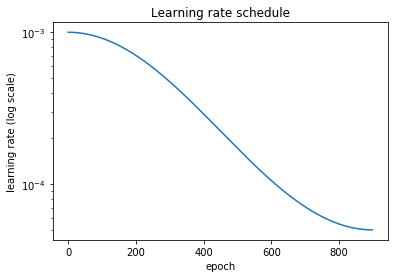

In [8]:
#new_lr = lambda org_lr, log_range, epoch, total_epochs: org_lr*(1.-epoch/total_epochs)
#new_lr = lambda org_lr, epoch, total_epochs: org_lr*(1.-epoch/total_epochs)/(epoch+1)
#new_lr = lambda org_lr, log_range, epoch, total_epochs: np.power(10, -(-log(org_lr, 10)*np.exp(epoch/total_epochs)))
#new_lr = lambda org_lr, log_range, epoch, total_epochs: np.power(10, -(log_range*(-np.cos(np.pi*(epoch/total_epochs))+1.)-log(org_lr, 10)-log_range))
#new_lr = lambda start_lr, end_lr, epoch, total_epochs: np.power(10, (np.cos(np.pi*(epoch/total_epochs))/2.+.5)*abs(start_lr-end_lr) + end_lr)
#new_lr = lambda start_lr, end_lr, epoch, total_epochs: np.power(10, ((end_lr-start_lr)/total_epochs)*epoch + start_lr)

schedule = LearningRateScheduler(total_epochs, log(start_lr, 10), log(end_lr, 10), schedule_plan='log_cosine')

x = np.arange(total_epochs)
y = schedule.get_lr(x)
plt.title('Learning rate schedule')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('learning rate (log scale)')
plt.plot(x, y)
plt.show()


In [9]:
cir.train()
dec.train()

for epoch in range(total_epochs):
    epoch_losses = []
    for i, data in enumerate(dataloader):
        optim.zero_grad()
        data = data.to(device)
        x = cir(data)
        x = dec(x)
        loss = loss_fn(x, data)# Variable(data, requires_grad=False, device=device))
        loss.backward()
        optim.step()
        epoch_losses.append(loss.item())
        schedule.adjust_learning_rate(optim, epoch+float(i)/len(dataloader))
    el = np.mean(epoch_losses)
    losses.append(el)
    #if epoch % 10 == 0:
    print('\rEpoch: {}\tLoss: {:.2f}\tLearning rate: {:.6f}'.format(epoch, el, schedule.get_lr(epoch)), end='')


Epoch: 899	Loss: 876.90	Learning rate: 0.00005038

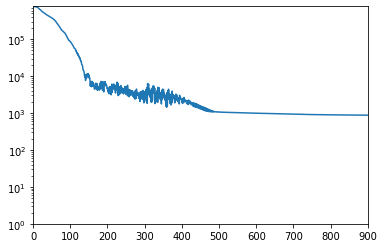

In [10]:
plt.yscale('log')
plt.plot(losses)
plt.xlim(0, len(losses))
plt.ylim(1, max(losses))
plt.show()

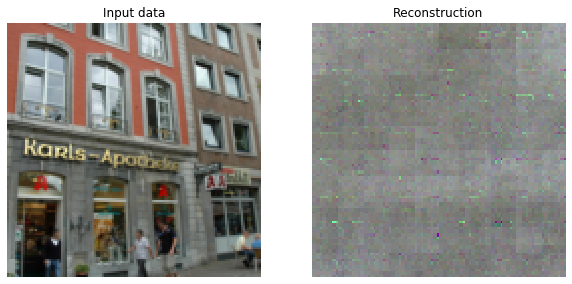

In [11]:
def torch_to_plt(img, stats=None):
    img = img.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    if stats is not None:
        img = stats[1]*img+stats[0]
    img -= img.min()
    img /= img.max()
    return img

cir.eval()
dec.eval()
test_data = dataset[0]
recon = dec(cir(test_data.unsqueeze(0).to(device)))


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
img = torch_to_plt(test_data, stats)
ax.imshow(img)
ax.axis('off')
ax.set_title('Input data')
ax = fig.add_subplot(1, 2, 2)
img = torch_to_plt(recon, stats=stats)
ax.imshow(img)
ax.axis('off')
ax.set_title('Reconstruction')
plt.show()